In [74]:
import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
import bayespy 

import pymc3 as pm
import arviz as az

# pd.set_option('display.max_columns', None)

from utils import *

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

#%load_ext watermark
#%watermark -dtmvgp numpy,scipy,matplotlib,pandas,seaborn,pymc3,theano,arviz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
data_netw = pd.read_csv(r'x:\CAO\Team\Data Science\performance_link\Bayesian_MLR_Starkis\data\tv_network.csv')
data_dig = pd.read_csv(r'x:\CAO\Team\Data Science\performance_link\Bayesian_MLR_Starkis\data\tv_digital.csv').drop(columns='TOTAL_CONV')

In [69]:
data = pd.concat([data_netw, data_dig], axis= 1)

In [71]:
# Filter the rows where sum of the values = 0
data = data[data.iloc[:,:-1].sum(axis=1)!=0]

AttributeError: module 'scipy' has no attribute 'sparse'

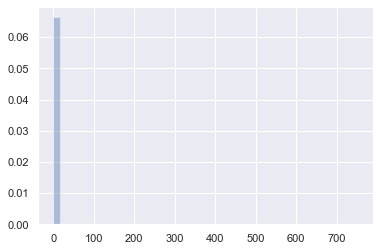

In [76]:
sns.distplot(data['TOTAL_CONV'], fit = norm)

In [ ]:
def target_distribution(target):
    """
    Plot Histogram and boxplot for target variable
    params: target - Series, np.array
    """
    fig = plt.figure(figsize=(12,6))
    plt.subplot(2,1,1)
    plt.ylabel('Frequency')
    sns.distplot(target, fit = norm)
    plt.subplot(2,1,2)
    plt.boxplot(target, vert = False)
    plt.xlabel('Price')
    return plt.show()

AttributeError: module 'scipy' has no attribute 'sparse'

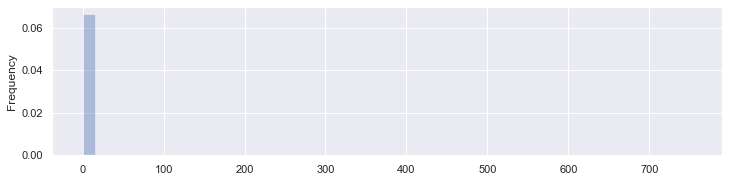

In [75]:
target_distribution(data.TOTAL_CONV)

In [31]:
x = data[[col for col in data.columns if col != 'TOTAL_CONV']].values
y = data.TOTAL_CONV.values

In [32]:
with pm.Model() as model_mlr_log:
    
    # Intercept
    alpha = pm.Normal('alpha', mu=1, sd=10)
    
    # Slope
    beta = pm.HalfNormal('beta', sd =50, shape = len(data.columns[:-1]))
    
    # Error term
    eps = pm.HalfCauchy('eps', 5)
    
    # Expected value of outcome (ML Regression with vectors)
    mu = alpha + pm.math.dot(x, beta)
    #alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(x_mean, beta))
    
    # Likelihood
    conversion = pm.Lognormal('conversion', mu= mu, sigma= eps, observed=y)
    
    # posterior
    trace_log = pm.sample(chains = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 133 seconds.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
The acceptance probability does not match the target. It is 0.89522612879401, but should be close to 0.8. Try to increase the number of tuning steps.


In [34]:
trace_log.varnames

['alpha', 'beta_log__', 'eps_log__', 'beta', 'eps']

In [ ]:
az.summary(trace_log,
           var_names = varnames[-1]
          ).set_index(data[[col for col in data.columns if col != 'TOTAL_CONV']].columns])

### GLM Student

In [41]:
# Lets look at intercepts
varnames = ['alpha', 'eps', 'beta']
# az.summary(trace_log, var_names = varnames[-1]).set_index([col for col in data.columns if col != 'TOTAL_CONV'])

In [54]:
# Formula for Bayesian Linear Regression
formula = 'TOTAL_CONV ~ ' + ' + '.join(['%s' % variable for variable in 
                                       data[[col for col in data.columns if col != 'TOTAL_CONV']].columns])
formula

'TOTAL_CONV ~ TV_ANE + TV_AMC + TV_ANIMALPLANET + TV_BBCAMERICA + TV_BET + TV_BETHER + TV_BRAVO + TV_COMEDYCENTRAL + TV_COUNTRYMUSICTELEVISION + TV_FOODNETWORK + TV_GAMESHOWNETWORK + TV_IFC + TV_INVESTIGATIONDISCOVERY + TV_LIFETIME + TV_LIFETIMEMOVIES + TV_OPRAHWINFREYNETWORK + TV_OTHER + TV_OVATIONTV + TV_PARAMOUNTNETWORK + TV_POP + TV_SMITHSONIANNETWORK + TV_SYFY + TV_TRUTV + TV_TVONE + TV_USANETWORK + TV_VH1 + TV_WETV + DIGITAL_HX + DIGITAL_TREMOR'

In [56]:
# Context for the model
with pm.Model() as model_glm_student:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.StudentT()
    
    # Creating the model requires a formula and data (and optionally a family)
    conv  = pm.GLM.from_formula(formula, data = data, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    trace_glm_student = pm.sample(chains = 4, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [lam, DIGITAL_TREMOR, DIGITAL_HX, TV_WETV, TV_VH1, TV_USANETWORK, TV_TVONE, TV_TRUTV, TV_SYFY, TV_SMITHSONIANNETWORK, TV_POP, TV_PARAMOUNTNETWORK, TV_OVATIONTV, TV_OTHER, TV_OPRAHWINFREYNETWORK, TV_LIFETIMEMOVIES, TV_LIFETIME, TV_INVESTIGATIONDISCOVERY, TV_IFC, TV_GAMESHOWNETWORK, TV_FOODNETWORK, TV_COUNTRYMUSICTELEVISION, TV_COMEDYCENTRAL, TV_BRAVO, TV_BETHER, TV_BET, TV_BBCAMERICA, TV_ANIMALPLANET, TV_AMC, TV_ANE, Intercept]


RuntimeError: Chain 0 failed.